In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import cv2
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import collections
import torch
from torch import nn
from torch.utils.data import TensorDataset
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time

%matplotlib inline

# Deklarasi Class Encoder, Decoder, dan Deep SMOTE

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()#args=>channel=3

        self.channel_img = 3 # rgb
        self.hidden_size = 64 # neuron
        self.flatten_size = 100 # feature extraction

        self.conv = nn.Sequential(
            nn.Conv2d(self.channel_img, self.hidden_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size, self.hidden_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 2, self.hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 4, self.hidden_size * 8, 4, 2, 1, bias=False),

            nn.BatchNorm2d(self.hidden_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(self.hidden_size * (2**3) *14*14, self.flatten_size)

    def forward(self, x):
        x = self.conv(x).reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        #setting arguments
        self.channel_img = 3
        self.hidden_size = 64
        self.flatten_size = 100

        #layers decoder
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, self.hidden_size * 8 * 14 * 14),
            nn.ReLU(0.2)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_size * 8, self.hidden_size * 4, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 4, self.hidden_size *2, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 2, self.hidden_size, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size, self.channel_img, 4,2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.deconv(self.fc(x).reshape(x.size(0), self.hidden_size * 8, 14, 14))
        return x

In [ ]:
import torch
import time
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pickle

class DeepSMOTE:
    def __init__(self, encoder, decoder, epochs):
        self.encoder    = encoder
        self.decoder    = decoder
        self.criterion  = nn.MSELoss()
        self.epochs     = epochs
        self.perform = {'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

    def compile(self, lr):
        self.enc_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
        self.dec_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=lr)

    def preprocess(self, X):
        self.minibatch = X
        self.data_x = self.minibatch['images'].permute(0,3,1,2)/255.0
        self.data_y = self.minibatch['class']

        self.classes = torch.unique(self.minibatch['class']).numpy()

        self.dataTensor = TensorDataset(self.data_x, self.data_y)
        self.train_loader = DataLoader(self.dataTensor, batch_size = 100, shuffle=True, num_workers = 0)

    def save_encode_decode(self, level):
        torch.save(self.encoder.state_dict(), level+"_encode.pth")
        torch.save(self.decoder.state_dict(), level+"_decode.pth")

    def fit(self, X, device):
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        self.criterion = self.criterion.to(device)

        self.preprocess(X)
        self.compile(lr=0.001)
        time_start = time.time()
        best_loss = 99

        #training with epoch
        for epoch in range(self.epochs):
            train_loss      = 0
            rec_loss        = 0
            penalty_loss    = 0
            self.encoder.train()
            self.decoder.train()

            # batching on train_loader
            for images, labels in self.train_loader:
                # Stop when current batch' size is less than train_loader' batch size
                if images.shape[0] < 100:
                    break
                self.encoder.zero_grad()
                self.decoder.zero_grad()

                images = images.to(device)
                labels_np = labels.detach().cpu().numpy()

                #encode-decode every batch
                mse = self.criterion(self.decoder(self.encoder(images)), images)

                #select class dan pengacakan class (CD)
                class_cd = np.random.choice(self.classes)
                x_cd = images[labels == class_cd]
                y_cd = labels[labels == class_cd]

                size_x = len(x_cd)
                i_shuffle = np.random.choice(list(range(size_x)), size_x, replace = False )
                xclass_cd = images[i_shuffle]
                yclass_cd = labels[i_shuffle]

                #Pengacakan anggota class CD menjadi cb
                size_cd = len(xclass_cd)
                j_shuffle = np.random.choice(list(range(size_cd)), size_cd, replace = False)
                xclass_cb = xclass_cd[j_shuffle]

                #encode xclass cd
                xclass_cd = xclass_cd.to(device)
                xclass_es = self.encoder(xclass_cd).detach()

                #permute encode cd #menggunakan pengacakan cb, indeksnya akan dicocokan dengan CD sebelum diekstrak
                xclass_pe = xclass_es[j_shuffle]

                #decode dp
                xclass_pe = xclass_pe.to(device)
                xclass_dp = self.decoder(xclass_pe)

                #penalty loss
                mse2 = self.criterion(xclass_dp, xclass_cb)

                combo_loss = mse + mse2
                combo_loss.backward()

                self.enc_optimizer.step()
                self.dec_optimizer.step()

                train_loss += combo_loss.item()
                rec_loss += mse.item()
                penalty_loss += mse2.item()

            #hitung training loss setiap epoch berdasarkan jumlah train loader
            train_loss = train_loss / len(self.train_loader)
            rec_loss = rec_loss / len(self.train_loader)
            penalty_loss = penalty_loss / len(self.train_loader)
            # 'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

            self.perform['train_loss'].append(train_loss)
            self.perform['rec_loss'].append(rec_loss)
            self.perform['penalty_loss'].append(penalty_loss)
            print(f"Epoch :{epoch+1} Train Loss: {train_loss} Rec Loss: {rec_loss} Penalty_loss: {penalty_loss}")

            if train_loss < best_loss:
                print("Menyimpan Model ....")
                self.save_encode_decode("best")
                best_loss = train_loss

                time_stop = time.time()
                self.timer = (time_stop - time_start)/60

                with open('model_perform.pkl', 'wb') as file:
                    # A new file will be created
                    pickle.dump(self.perform, file)

    def generate_samples(
            self,
            limit,
            target,
            device,
            path_encoder = "best_encode.pth",
            path_decoder = "best_decode.pth"
        ):

        self.gen_timer = time.time()
        self.encoder.load_state_dict(torch.load(path_encoder, map_location=device), strict=False)
        self.decoder.load_state_dict(torch.load(path_decoder, map_location=device), strict=False)

        self.encoder.to(device)
        self.decoder.to(device)

        self.encoder.eval()
        self.decoder.eval()

        gen_x = []
        gen_y = []
        for cls in self.classes:

            # process data
            x_class = self.data_x[self.data_y == cls]
            y_class = self.data_y[self.data_y == cls]

            x_class_l = x_class[:limit]
            y_class_l = y_class[:limit]

            x_class_l = x_class_l.to(device)

            #encodering
            x_class_l = self.encoder(x_class_l).detach().cpu()

            # ==== START SMOTE ====
            n_generate = target - len(y_class)
            #knn training for nearest neighbor
            kNN = NearestNeighbors(n_neighbors=5, n_jobs=1)
            kNN.fit(x_class_l)
            dist, ind = kNN.kneighbors(x_class_l)

            #generatting random index
            base = np.random.choice(list(range(len(x_class_l))), n_generate)

            NNindex = np.random.choice(list(range(5)), n_generate)

            X_base = x_class_l[base]
            X_nn = x_class_l[ind[base, NNindex]]

            #generate
            generate_sample = X_base + torch.mul(torch.from_numpy(np.random.rand(n_generate,1)),
                                                X_nn - X_base)

            x_sample, y_sample = generate_sample, torch.tensor([cls]*n_generate) #output torch dtype
            # ==== END SMOTE ====
            x_sample = x_sample.float().to(device)

            #decodering
            x_decode = self.decoder(x_sample).detach().cpu()
            x_decode = x_decode.permute(0,2,3,1)*255.0

            # TEMPORARY CODE : save plot comparison between image base, neighbor and generated using matplotlib
            for i in range(n_generate):
                # save plot (x_class_l[base], x_class_l[ind[base,NNindex]]), x_decode
                fig, axs = plt.subplots(ncols=3, figsize=(7, 3))
                fig.suptitle('Sample Images')

                axs[0].imshow(x_class[base[i]].permute(1, 2, 0))
                axs[0].set_title('base image')
                axs[0].set_axis_off()

                axs[1].imshow(x_class[ind[base, NNindex][i]].permute(1, 2, 0))
                axs[1].set_title('neighbor image')
                axs[1].set_axis_off()

                axs[2].imshow(x_decode[i] / 255)
                axs[2].set_title('generated image')
                axs[2].set_axis_off()

                plt.savefig(f'image_comparison/comparison_class_{cls}_{i}.png', dpi=100, transparent=False, pad_inches=0)

            #saving
            gen_x.append(x_decode.to(dtype=torch.float16))
            gen_y.append(y_sample)

        # combine result torch all of class in one tensor

        combine_gen = {
            'images': torch.cat(gen_x, dim=0),
            'class': torch.cat(gen_y, dim=0)
        }
        with open('combine_oversampling.pkl', 'wb') as file:

            # A new file will be created
            pickle.dump(combine_gen, file)

        #combine result torch with data
        self.combine_data = {
            'images':torch.cat(
                [
                    (self.data_x.permute(0,2,3,1)*255.0).to(dtype=torch.float16),
                    torch.cat(gen_x, dim=0)
                ],
                dim=0
            ),
            'class':torch.cat(
                [
                    self.data_y,
                    torch.cat(gen_y, dim=0)
                ],
                dim=0)
            }

        with open('combine_oversampling_with_data.pkl', 'wb') as file:
            pickle.dump(self.combine_data, file)

        self.gen_timer = time.time()-self.gen_timer
        print(self.gen_timer/60)

In [ ]:
def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(os.listdir(path)):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = np.uint8)
    labels = np.array(labels, dtype = np.uint8)

    return (images, labels)

# Deep SMOTE data training tanpa CLAHE

## Load data training

In [ ]:
images, labels = load_data(path="/content/drive/MyDrive/SKRIPSI/dataset/train")

Loading /content/drive/MyDrive/SKRIPSI/dataset/train


100%|██████████| 643/643 [00:09<00:00, 64.47it/s] 


## Training model

In [ ]:
len(labels[labels==0])

788

In [ ]:
deepsmote = DeepSMOTE(Encoder(), Decoder(), epochs=100)

In [ ]:
deepsmote.fit(
    X={
        'images': torch.tensor(images, dtype=torch.uint8),
        'class': torch.tensor(labels, dtype=torch.uint8)
    },
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

KeyboardInterrupt: 

## Menampilkan nilai loss setiap epoch

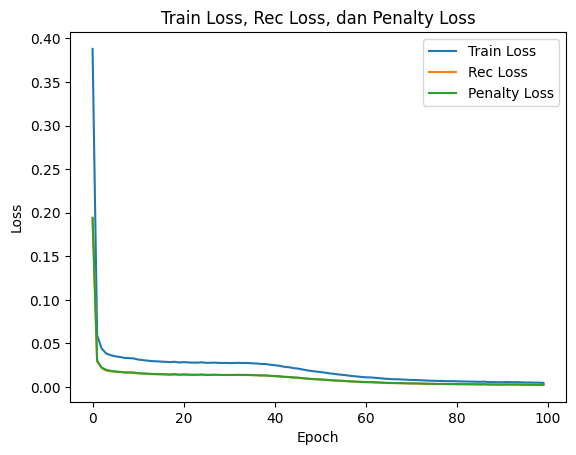

In [ ]:
# write_cachedImg(args['oversample']+"_perform.pkl")
performa=deepsmote.perform
plt.plot(performa['train_loss'], label='Train Loss')
plt.plot(performa['rec_loss'], label='Rec Loss')
plt.plot(performa['penalty_loss'], label='Penalty Loss')

# Menambahkan label dan judul plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss, Rec Loss, dan Penalty Loss')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

In [ ]:
import os
import shutil

# Create the directory
directory_path = "/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")


# Copy the model files
source_files = [
    "best_decode.pth",
    "best_encode.pth",
    "model_perform.pkl"
]

for file in source_files:
    if os.path.exists(file):
        destination_path = os.path.join(directory_path, file)
        shutil.copy(file, destination_path)
        print(f"File '{file}' copied to '{destination_path}'")
    else:
        print(f"Warning: Source file '{file}' not found. Skipping copy.")

Directory '/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model' already exists.
File 'best_decode.pth' copied to '/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/best_decode.pth'
File 'best_encode.pth' copied to '/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/best_encode.pth'
File 'model_perform.pkl' copied to '/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/model_perform.pkl'


In [ ]:
os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/train")

['Early', 'Benign', 'Pre', 'Pro']

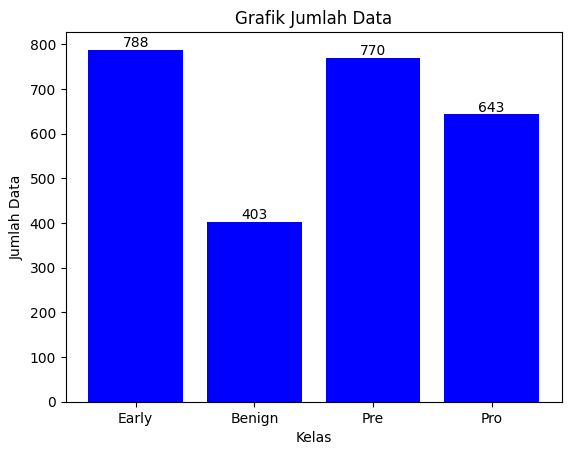

In [ ]:
classes = [ kelas for kelas in os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/train") ]

n_data = [ labels[labels==i].shape[0] for i in range(4) ]

fig, axs = plt.subplots(3)
fig.suptitle('Vertically ')
axs[0].plot(x, y)
axs[1].plot(x, -y)

plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')

for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

## Generate image

In [ ]:
torch.tensor(images, dtype=torch.uint8)[0] /255

torch.Size([2604, 224, 224, 3])

In [ ]:
deepsmote.preprocess(
    X={
        'images': torch.tensor(images, dtype=torch.uint8),
        'class': torch.tensor(labels, dtype=torch.uint8)
})
deepsmote.generate_samples(
    limit=300,
    target=788,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    path_encoder="/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/best_encode.pth",
    path_decoder="/content/drive/MyDrive/SKRIPSI/DeepSMOTE Model/best_decode.pth"
)

2.529465925693512


In [ ]:
with open('combine_oversampling_with_data.pkl', 'rb') as file:
    combine_data = pickle.load(file)

combine_data['images'].shape

torch.Size([3152, 224, 224, 3])

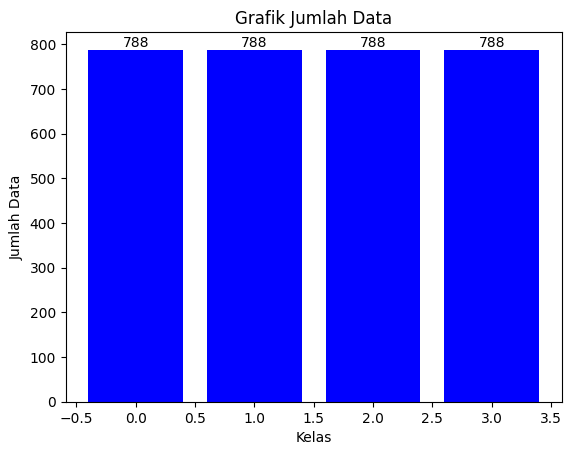

In [ ]:
classes = [ i for i in range(4) ]

n_data = [ combine_data['class'][combine_data['class']==i].shape[0] for i in range(4) ]

plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')

for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

In [ ]:
# with open('combine_oversampling.pkl', 'rb') as file:
with open('combine_oversampling.pkl', 'rb') as file:
    generated_data = pickle.load(file)

## Menampilkan sample image yang di-generate menggunakan Deep SMOTE

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(7, 3))
fig.suptitle('Sample Images')
for i in range(3):
    axs[i].imshow(generated_data['images'][generated_data['class']==i+1][10].to(torch.uint8))
    axs[i].set_title('generated_data')
    axs[i].set_axis_off()

plt.savefig('comparison.png', dpi=100, transparent=False, pad_inches=0)

In [ ]:
len(generated_labels[generated_labels==0])

0

In [ ]:
generated_labels = generated_data['class']

<Figure size 800x11500 with 0 Axes>

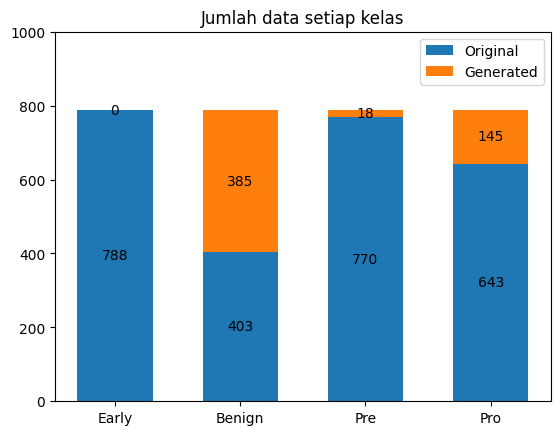

In [ ]:
classes = [ kelas for kelas in os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/train") ]
data_counts = {
    'Original': [
        len(labels[labels==i]) for i in range(len(classes))
    ],
    'Generated': [
        len(generated_labels[generated_labels==i]) for i in range(len(classes))
    ],
}
width = 0.6  # the width of the bars: can also be len(x) sequence

plt. figure(figsize=(8, 115))

fig, ax = plt.subplots()
bottom = np.zeros(4)

for sex, data_count in data_counts.items():
    p = ax.bar(classes, data_count, width, label=sex, bottom=bottom)
    bottom += data_count

    ax.bar_label(p, label_type='center')

ax.set_title('Jumlah data setiap kelas')
# ax.set_ymargin(100)
plt.ylim(0, 1000)
# ax.set_ylabel('Number of penguins')
# ax.set_xlabel('Sex')
ax.legend()

plt.show()